In [1]:
import numpy as np
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
train_dir = 'Cat_Dog_data/train'
test_dir = 'Cat_Dog_data/test'

train_transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                #transforms.RandomRotation(10),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])

test_transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [4]:
# seting the persentage of the validation size th 20%
val_size = 0.2
batch_size = 32
# obtain training indices that will be used for validation
len_train_set = len(train_data)

# create a list that will hold all the indeces of the trainning dataset and shuffle this list
indices = list(range(len_train_set))
np.random.shuffle(indices)

# np.floor(a) ---> gives the smalest int value closest to a
split = int(np.floor(val_size * len_train_set))

# isn't this beautiful... God!!! I love python 
train_idx, val_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [5]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=val_sampler)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = True)

In [6]:
# specify the image classes
classes = ["Cat", "Dog"]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

tensor(1)


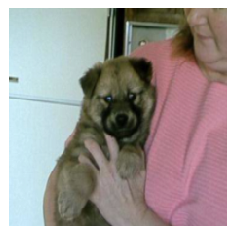

In [8]:
train_loader
images, lables = next(iter(train_loader))
img_idx = 7
img = images[img_idx]

imshow(img, normalize = True)
img.shape
print(lables[img_idx])

In [ ]:
"""from collections import OrderedDict
classifier = nn.Sequential(OrderedDict(
[
    ("fc1", nn.Linear(2048, 1024)),
    ("relu", nn.ReLU()),
    ("fc2", nn.Linear(1024, 2)),
    ("output", nn.LogSoftmax(dim = 1))
]))
model.fc = classifier
for parm in model.parameters():
    parm.requires_grad = False
    
model.cuda()
model"""

In [40]:
model = models.resnet50(pretrained = True)
classifier = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 2),
    nn.LogSoftmax(dim = 1))
model.fc = classifier
for parm in model.parameters():
    parm.requires_grad = False
for parm in model.fc.parameters():
    parm.requires_grad = True

if train_on_gpu:
    model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [41]:
import torch.optim as optim

# specify loss function
criterion = nn.NLLLoss()
# specify optimizer
optimizer = optim.Adam(model.fc.parameters(), lr = 0.00001,  weight_decay=0.01)

In [42]:
epochs = 15
train_losses, valid_losses, test_losses = [], [], []

In [43]:
# number of epochs to train the model
import time

print("Training started...")

valid_loss_min = np.Inf # track change in validation loss and we make it infinity to see it go down

for e in range(1, epochs+1):
    tic = time.time()
    # keep track of training and validation loss per bathc
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    #model.train()
    #for parm in model.parameters():
    #    parm.requires_grad = False
    
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        # I don't get why we have to multiply by batch size "*images.size(0)"
        train_loss += loss.item()*images.size(0)
        #train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    
    print("Validating the model")
    
    model.eval()
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        
        
        valid_loss += loss.item()*images.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_losses.append(train_loss)    
    valid_losses.append(valid_loss)
    # print training and validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
              .format(valid_loss_min, valid_loss))
        
        torch.save(model.state_dict(), 'Model states/cat_and_dog_resnet50.pt')
        
        valid_loss_min = valid_loss
        
    toc = time.time()
    print(str((toc - tic) * 1000) + "ms")

Training started...
Validating the model
Epoch: 1 	Training Loss: 0.232912 	Validation Loss: 0.032813
Validation loss decreased (inf --> 0.032813).  Saving model ...
200475.13031959534ms
Validating the model
Epoch: 2 	Training Loss: 0.109033 	Validation Loss: 0.026203
Validation loss decreased (0.032813 --> 0.026203).  Saving model ...
198625.0855922699ms
Validating the model
Epoch: 3 	Training Loss: 0.095471 	Validation Loss: 0.023469
Validation loss decreased (0.026203 --> 0.023469).  Saving model ...
198872.00212478638ms
Validating the model
Epoch: 4 	Training Loss: 0.088610 	Validation Loss: 0.023154
Validation loss decreased (0.023469 --> 0.023154).  Saving model ...
198481.64248466492ms
Validating the model
Epoch: 5 	Training Loss: 0.085026 	Validation Loss: 0.021841
Validation loss decreased (0.023154 --> 0.021841).  Saving model ...
200887.4168395996ms
Validating the model
Epoch: 6 	Training Loss: 0.083492 	Validation Loss: 0.022103
200195.35446166992ms
Validating the model
Epo

In [44]:
model.load_state_dict(torch.load('Model states/cat_and_dog_resnet50.pt'))

In [45]:
test_loss = 0.0

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data

for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    test_losses.append(test_loss)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        f = target.data[i]
        class_correct[f] += correct[i].item()
        class_total[f] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.043223

Test Accuracy of   Cat: 97% (1224/1250)
Test Accuracy of   Dog: 98% (1233/1250)

Test Accuracy (Overall): 98% (2457/2500)


In [46]:
%matplotlib inline
%config IOnlineBackended.figure_format = 'retina'
import matplotlib.pyplot as plt

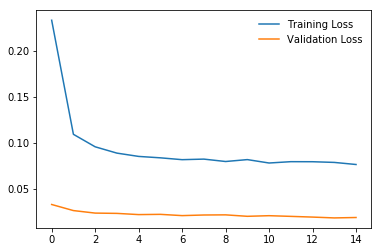

In [48]:
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label = "Validation Loss")
plt.legend(frameon=False)